In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [78]:
#read in the MESA models
mesa_out=np.loadtxt('1.5M_at_TAMS.txt',unpack=True)
T_mesa=mesa_out[2]
d_mesa=mesa_out[1]
R_mesa=mesa_out[3]
L_mesa=mesa_out[4]
m_frac_mesa=mesa_out[5]

In [ ]:
#Let X=0.7121, Y=0.2766, Z=0.0154, M=1 Solar Mass

In [241]:
#load in opacity table from OPAL library
opacity_table=np.loadtxt('Solar_opacities.txt',unpack=True)
log_R_tab=np.array([-8,-7.5,-7.0,-6.5,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0])
log_T=opacity_table[0]

In [242]:
#make a variable for the appropriate rows in the opacity table
from scipy import interpolate
opacities=opacity_table[1:20]

In [243]:
#write a function that takes in density and temperature, and interpolates an opacity based on the table
def inter_opac(den,T):
    log_T_in=np.log10(T)
    R_in=den/(T*1e-6)**3
    log_Rin=np.log10(R_in)
    Temp,R=np.meshgrid(log_T,log_R_tab)
    f=interpolate.interp2d(Temp,R,opacities)
    return 10**f(log_T_in,log_Rin)

In [245]:
#verify that the function works
np.log10(inter_opac(1e-14,10**4))

array([-0.527])

In [ ]:
#Now we will verify that the interpolation function can reproduce the opacities in the table
#This computes the temperature range and density for a given R value in the table to compare to our function
Ts=np.arange(3.75,7.5,0.1)
dens=10**(1)*(10**Ts/1e6)**3

In [246]:
#compute opacities at the specific R using the inerpolation function
opac=[]
for i in range(len(dens)):
    opac.append((inter_opac(dens[i],10**Ts[i])))


<IPython.core.display.Javascript object>


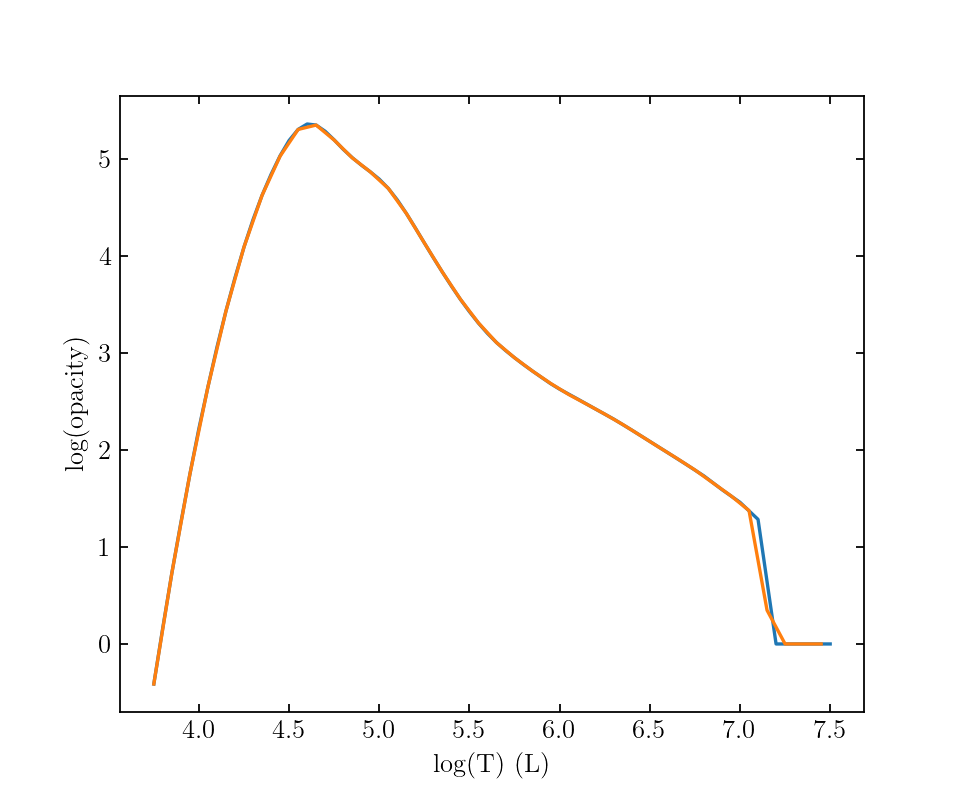

Text(0, 0.5, 'log(opacity)')

In [251]:
#Now we plot both the interpolated opacities and those in the table at the specific R value and they seem to match
%matplotlib notebook
plt.plot(log_T,(opacities[-1]))
plt.plot(Ts,np.log10(opac))
plt.xlabel('log(T) (L)')
plt.ylabel('log(opacity)')

In [18]:
# Now we have to define functions for calculating the energy generation from pp-chain and CNO cycle
#the f11 and g11 functions are inputs into the equation for the pp-chain energy eneration
def f11(den,T):
    Ekt=5.92e-3*(den/(T*1e-7)**3)**0.5
    f=np.exp(Ekt)
    return f

In [19]:
def g11(T):
    T9=T*1e-9
    g=(1+3.82*T9+1.51*T9**2+0.144*T9**3-0.114*T9**4)
    return g

In [20]:
#this function calculates energy from the pp-Chain by inputting a density and temperature
def epp(den,T):
    g=g11(T)
    f=f11(den,T)
    X1=0.7
    T9=T*1e-9
    epp=2.57e4*f*g*den*X1**2*T9**(-2/3)*np.exp(-3.381/T9**(1/3))
    return epp

In [21]:
#now we switch to the CNO cycle, and g14 is a value that inputs into the CNO energy generation, and it depends on T
def g14(T):
    T9=T*1e-9
    g14=(1-2*T9+3.41*T9**2-2.43*T9**3)
    return g14

In [22]:
#This function returns the energy generation from the CNO cycle for a given temperature and density
def ecno(den,T):
    XCNO=0.02*2/3
    X1=0.7
    T9=T*1e-9
    ex_term=-15.231*T9**(-1/3)-(T9/0.8)**2
    ecno=8.24e25*g14(T)*XCNO*X1*den*T9**(-2/3)*np.exp(ex_term)
    return ecno

In [23]:
#Now we write a function that sums the CNO cycle and pp-chain energy
def en_gen(den,T):
    pp_chain=epp(den,T)
    cno=ecno(den,T)
    total_e=pp_chain+cno
    return total_e

<IPython.core.display.Javascript object>


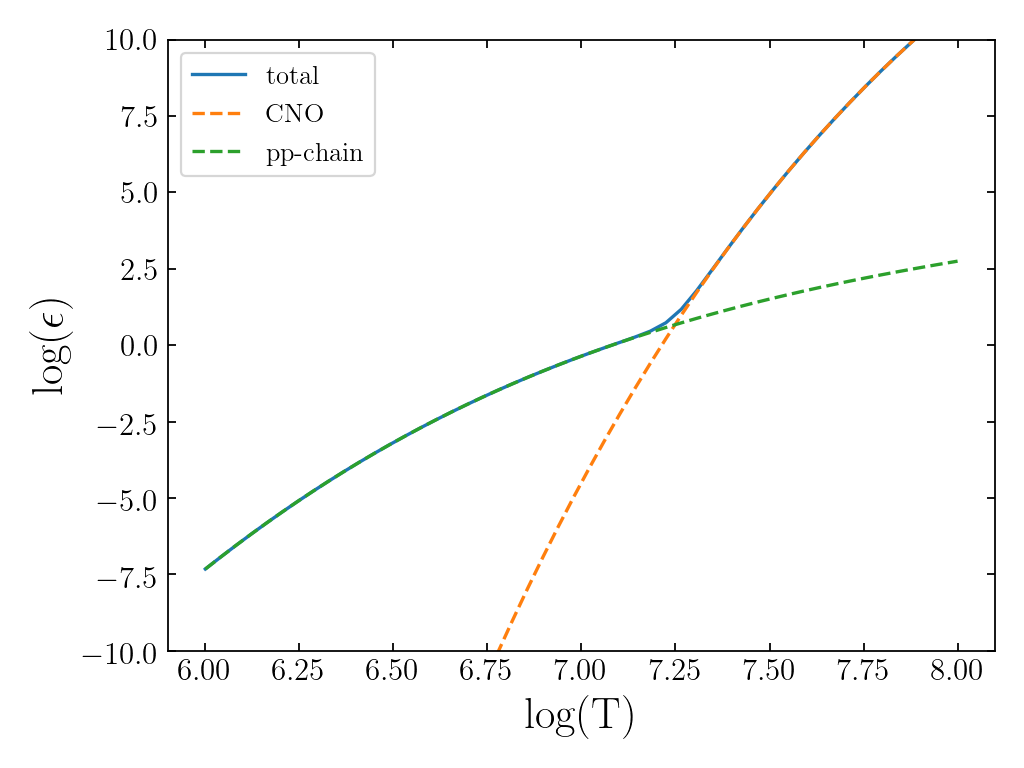

In [153]:
#plot the energy generation from CNO and pp-chain to check its correctness
%matplotlib notebook
plt.rc('font', size=12, family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', direction='in', top=True)
plt.rc('ytick', direction='in', right=True)
x=np.linspace(6, 8, 50)
y = np.log10(en_gen(10,10**x))
plt.plot(x,y,label='total')
plt.plot(x,np.log10(ecno(10,10**x)),linestyle='--',label='CNO')
plt.plot(x,np.log10(epp(10,10**x)),linestyle='--',label='pp-chain')
plt.ylim(-10,10)
plt.xlabel('log(T)',fontsize=20)
plt.ylabel('log($\epsilon$)',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()
plt.tight_layout()
plt.savefig('en_gen.pdf')
plt.show()

In [25]:
#This function calculates the density given a specific P (where P is ideal gas and radiation) 
#and T and assuming that X=0.7
def den_calc(P,T):
    NA=6.022e23
    a=7.564e-15
    k=1.38e-16
    mu=4/(3+5*0.7) #assuming complete ionization
    den=(P-a/3*T**4)*(mu/NA/k/T) #solve for density including gas and radiation pressure
    return den

In [26]:
#This function calculates the adiabative and radiative gradients and determines which one to use
def dels(den,T,P,L,m):
    a=7.564e-15
    G=6.67e-8
    c=3e10
    kap=inter_opac(den,T)
    d_rad=3/16/3.14/a/c/G*P*kap/T**4*L/m
    del_ab=0.4
    if d_rad <= del_ab:
        del_use=d_rad
    else:
        del_use=del_ab
        
    return del_use

In [72]:
#The load1 function calculates the inital  guesses for the central boundary conditions
def load1(M,frac,X=0.7):
    R_tot=(M/2e33)**(0.75)*6.96e10
    Pc=1.34e15*(M/2e33)**2*(R_tot/6.96e10)**(-4)*10
    m=frac*M
    P=(Pc*(1-(m/M)**(2/3)))
    
    mu=4/(3+5*0.7)
    Tc=1.15e7*mu*(M/2e33)*(R_tot/6.96e10)**(-1)
    
    T=(Tc*(1-(m/M)**(2/3)))
    
    den_c=den_calc(Pc,Tc,X)
    l=en_gen(den_c,Tc)*m
    r=(m*3/4/3.14/den_c)**(1/3)
    return np.array([l,P,r,T])

In [71]:
#The load2 function calculates the inital guess for the surface boundary conditions
def load2(M,frac,X=0.7):
    sb=5.67e-5
    L_tot=(M/2e33)**(3.5)*3.83e33
    R_tot=(M/2e33)**(0.75)*6.96e10
    Teff=(L_tot/4/3.14/sb/R_tot**2)**(1/4)*2
    Ps=4e5
    return np.array([L_tot,Ps,R_tot,Teff])

In [30]:
#This is where we define the 4 differential equations of stellar structure
def derivs(v,m):
    l,P,r,T=v
    G=6.67e-8
    den=den_calc(P,T)
    del_use=dels(den,T,P,l,m)
    
    dldm=en_gen(den,T)
    dPdm=-G*m/4/3.14/r**4
    drdm=1/4/3.14/r**2/den
    dTdm=-G*m*T/4/3.14/r**4/P*0.4
    return np.array([dldm,dPdm,drdm,dTdm])

In [31]:
#This is the shoot function that calculates the residuals from integrating inward and outward
def shoot_func(params,M_star):
    Lin,Pin,Tin,Pout,Tout,Rout=params
    #Use logspace intervals for the mass coordinate
    m_inward=np.logspace(np.log10(0.5*M_star*2e33),np.log10(M_star*2e33),base=10,num=int(1e5))
    m_inward=np.flip(m_inward)
    m=np.logspace(np.log10(1e-13*M_star*2e33),np.log10(0.5*M_star*2e33),base=10,num=int(1e5))
    
    #compute the initial guesses for all quantities
    init_cent=load1(M_star*2e33,1e-13)
    l_cent,P_cent,r_cent,T_cent=init_cent
    
    init_surf=load2(M_star*2e33,1e-13)
    l_surf,P_surf,r_surf,T_surf=init_surf
    
    l_cent=l_cent*Lin
    #l_surf=l_surf*Lout
    
    P_cent=P_cent*Pin
    P_surf=P_surf*Pout

    T_cent=T_cent*Tin
    T_surf=T_surf*Tout
    
    r_surf=Rout*r_surf
    
    cent_in=[l_cent,P_cent,r_cent,T_cent]
    surf_in=[l_surf,P_surf,r_surf,T_surf]
    
    #integrate the equations
    cent_sol=odeint(derivs,cent_in,m)
    surf_sol=odeint(derivs,surf_in,m_inward)
    
    l_i_sol=cent_sol[:,0]
    P_i_sol=cent_sol[:,1]
    r_i_sol=cent_sol[:,2]
    T_i_sol=cent_sol[:,3]
    
    l_s_sol=surf_sol[:,0]
    P_s_sol=surf_sol[:,1]
    r_s_sol=surf_sol[:,2]
    T_s_sol=surf_sol[:,3]
    
    l_i_point=l_i_sol[-1]
    P_i_point=P_i_sol[-1]
    r_i_point=r_i_sol[-1]
    T_i_point=T_i_sol[-1]
    
    l_s_point=l_s_sol[-1]
    P_s_point=P_s_sol[-1]
    r_s_point=r_s_sol[-1]
    T_s_point=T_s_sol[-1]
    
    #Calculate the residuals
    l_res=(l_i_point*677-l_s_point)/l_i_point
    P_res=(P_i_point-P_s_point)/P_i_point
    r_res=(r_i_point-r_s_point)/r_i_point
    T_res=(T_i_point-T_s_point)/T_s_point
    
    residuals=np.array([l_res,P_res,r_res,T_res])
    res_sum=np.sum(residuals)
    print('Params=',params)
    print(residuals)
    return residuals
   

In [ ]:
#Use least_squares to minimize the residuals from the shoot function and print out the best fit parameters
from scipy.optimize import least_squares
bounds=([1e-1,1e-1,1e-1,1e-1,1e-1,1e-1],[1e3,1e3,1e3,1e3,1e3,1e3])
guess=[1.2,0.9,1,1,1.2,1]
sols=least_squares(shoot_func,x0=guess,bounds=bounds,args=[1.5])

In [33]:
#this function returns converged solution from the center using the best fit inital guesses
def sol_cent(params,M_star):
    Lin,Pin,Tin,Pout,Tout,Rout=params
    
    m_inward=np.logspace(np.log10(0.5*M_star*2e33),np.log10(M_star*2e33),base=10,num=int(1e5))
    m_inward=np.flip(m_inward)
    m=np.logspace(np.log10(1e-13*M_star*2e33),np.log10(0.5*M_star*2e33),base=10,num=int(1e5))
    
    init_cent=load1(M_star*2e33,1e-13)
    l_cent,P_cent,r_cent,T_cent=init_cent
    
    init_surf=load2(M_star*2e33,1e-13)
    l_surf,P_surf,r_surf,T_surf=init_surf
    
    l_cent=l_cent*Lin
    #l_surf=l_surf*Lout
    
    P_cent=P_cent*Pin
    P_surf=P_surf*Pout

    T_cent=T_cent*Tin
    T_surf=T_surf*Tout
    
    r_surf=Rout*r_surf
    
    cent_in=[l_cent,P_cent,r_cent,T_cent]
    surf_in=[l_surf,P_surf,r_surf,T_surf]
    
    cent_sol=odeint(derivs,cent_in,m)
    surf_sol=odeint(derivs,surf_in,m_inward)
    
    l_i_sol=cent_sol[:,0]
    P_i_sol=cent_sol[:,1]
    r_i_sol=cent_sol[:,2]
    T_i_sol=cent_sol[:,3]
    
    l_s_sol=surf_sol[:,0]
    P_s_sol=surf_sol[:,1]
    r_s_sol=surf_sol[:,2]
    T_s_sol=surf_sol[:,3]
    
    l_i_point=l_i_sol[-1]
    P_i_point=P_i_sol[-1]
    r_i_point=r_i_sol[-1]
    T_i_point=T_i_sol[-1]
    
    l_s_point=l_s_sol[-1]
    P_s_point=P_s_sol[-1]
    r_s_point=r_s_sol[-1]
    T_s_point=T_s_sol[-1]
    
    l_res=(l_i_point*677-l_s_point)/l_i_point
    P_res=(P_i_point-P_s_point)/P_i_point
    r_res=(r_i_point-r_s_point)/r_i_point
    T_res=(T_i_point-T_s_point)/T_s_point
    
    residuals=np.array([l_res,P_res,r_res,T_res])
    res_sum=np.sum(residuals)
    #print('Params=',params)
    print(residuals)
    return [l_i_sol,P_i_sol,r_i_sol,T_i_sol]

In [34]:
#this function returns converged solution from the surface using the best fit inital guesses
def sol_surf(params,M_star):
    Lin,Pin,Tin,Pout,Tout,Rout=params
    
    m_inward=np.logspace(np.log10(0.5*M_star*2e33),np.log10(M_star*2e33),base=10,num=int(1e5))
    m_inward=np.flip(m_inward)
    m=np.logspace(np.log10(1e-13*M_star*2e33),np.log10(0.5*M_star*2e33),base=10,num=int(1e5))
    
    init_cent=load1(M_star*2e33,1e-13)
    l_cent,P_cent,r_cent,T_cent=init_cent
    
    init_surf=load2(M_star*2e33,1e-13)
    l_surf,P_surf,r_surf,T_surf=init_surf
    
    l_cent=l_cent*Lin
    #l_surf=l_surf*Lout
    
    P_cent=P_cent*Pin
    P_surf=P_surf*Pout

    T_cent=T_cent*Tin
    T_surf=T_surf*Tout
    
    r_surf=Rout*r_surf
    
    cent_in=[l_cent,P_cent,r_cent,T_cent]
    surf_in=[l_surf,P_surf,r_surf,T_surf]
    
    cent_sol=odeint(derivs,cent_in,m)
    surf_sol=odeint(derivs,surf_in,m_inward)
    
    l_i_sol=cent_sol[:,0]
    P_i_sol=cent_sol[:,1]
    r_i_sol=cent_sol[:,2]
    T_i_sol=cent_sol[:,3]
    
    l_s_sol=surf_sol[:,0]
    P_s_sol=surf_sol[:,1]
    r_s_sol=surf_sol[:,2]
    T_s_sol=surf_sol[:,3]
    
    l_i_point=l_i_sol[-1]
    P_i_point=P_i_sol[-1]
    r_i_point=r_i_sol[-1]
    T_i_point=T_i_sol[-1]
    
    l_s_point=l_s_sol[-1]
    P_s_point=P_s_sol[-1]
    r_s_point=r_s_sol[-1]
    T_s_point=T_s_sol[-1]
    
    l_res=(l_i_point*677-l_s_point)/l_i_point
    P_res=(P_i_point-P_s_point)/P_i_point
    r_res=(r_i_point-r_s_point)/r_i_point
    T_res=(T_i_point-T_s_point)/T_s_point
    
    residuals=np.array([l_res,P_res,r_res,T_res])
    res_sum=np.sum(residuals)
    #print('Params=',params)
    print(residuals)
    return [l_s_sol,P_s_sol,r_s_sol,T_s_sol]

In [ ]:
#call both functions with the best fit parameters for convergence
cent_sols=sol_cent([1.20000004,0.6483801,1.03681952,0.99959541,1.94971272,0.9970586],1.5)
surf_sols=sol_surf([1.20000004,0.6483801,1.03681952,0.99959541,1.94971272,0.9970586],1.5)

In [208]:
#combine the inward and outward solutions
tempsol=np.concatenate((cent_sols[3],np.flip(surf_sols[3])))
Lsol=np.concatenate((cent_sols[0],np.flip(surf_sols[0])))
Psol=np.concatenate((cent_sols[1],np.flip(surf_sols[1])))
rsol=np.concatenate((cent_sols[2],np.flip(surf_sols[2])))

<IPython.core.display.Javascript object>


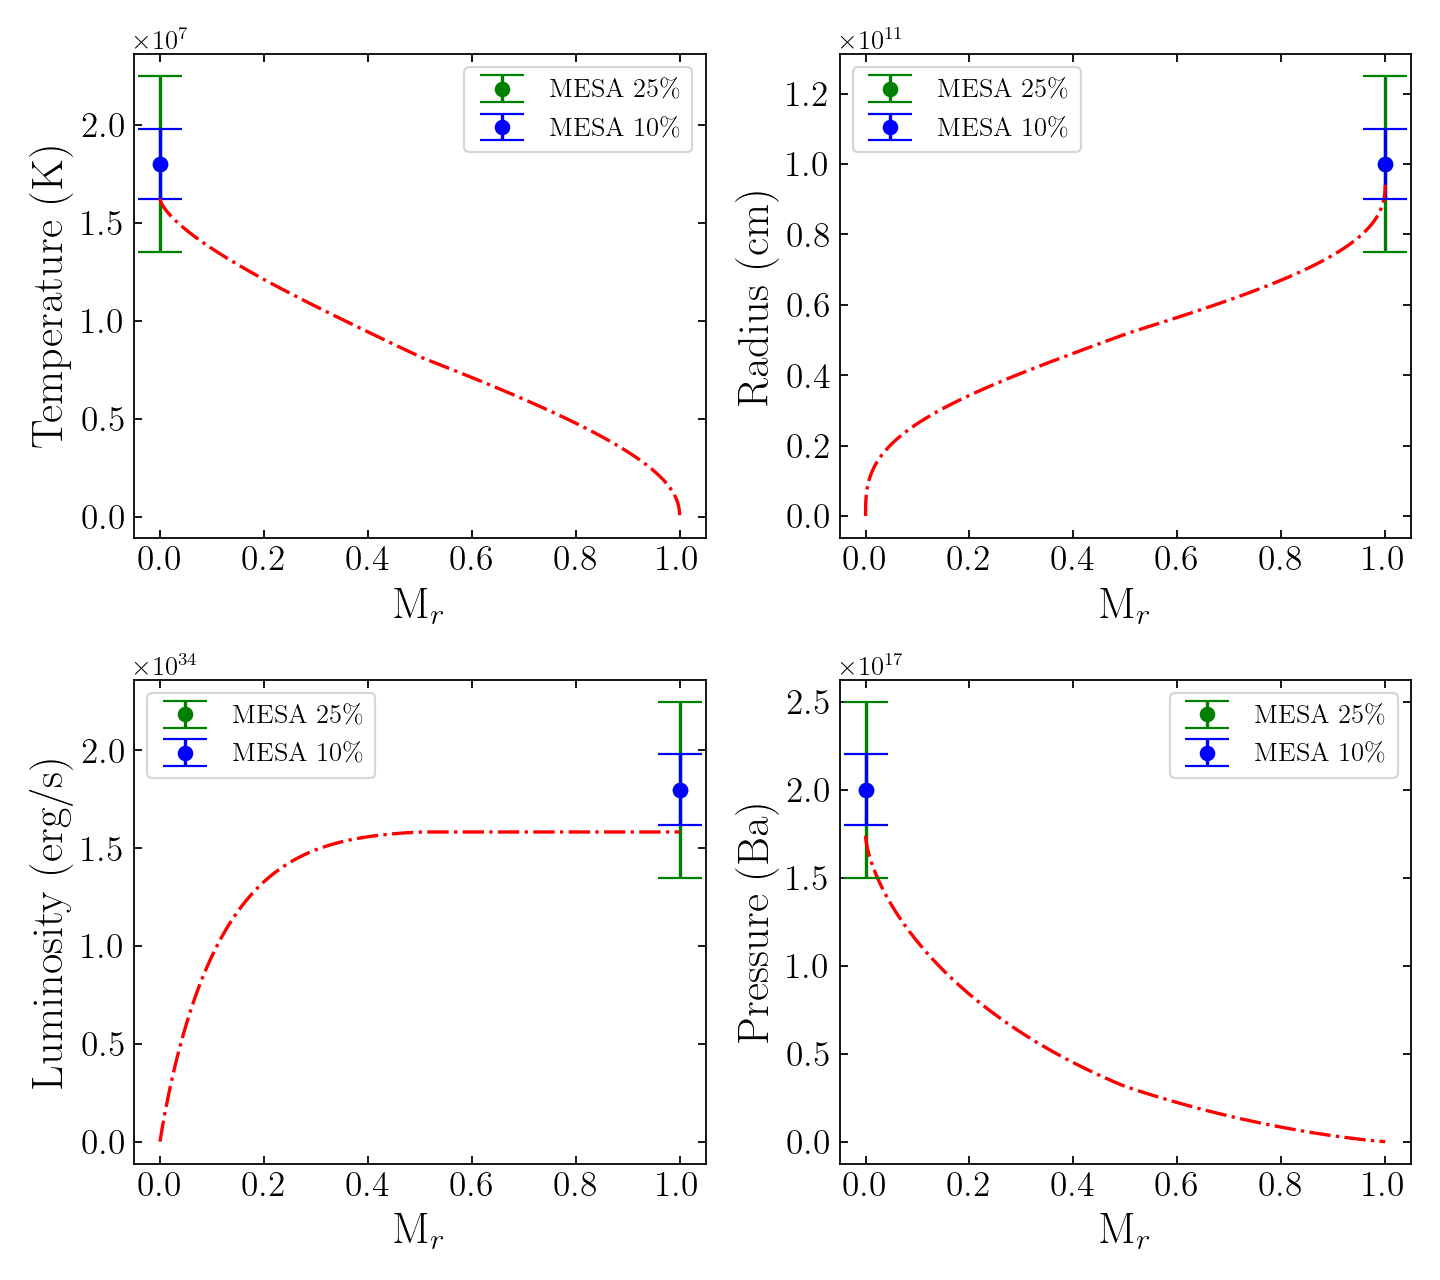

In [231]:
#plot the inward and outward solutions and compare with MESA
%matplotlib notebook
plt.rcParams["figure.figsize"] = (9,8)
plt.figure()
plt.subplot(2,2,1)
plt.errorbar(M_R_tot[0],1.8e7,yerr=1.8e7*0.25,color='g',marker='o',capsize=10,label='MESA 25$\%$',linestyle='none')
plt.errorbar(M_R_tot[0],1.8e7,yerr=1.8e7*0.1,color='b',marker='o',capsize=10,label='MESA 10$\%$',linestyle='none')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(M_R_tot,tempsol,color='r',linestyle='-.')


plt.ylabel('Temperature (K)',fontsize=20)
plt.xlabel('M$_{r}$',fontsize=20)
plt.legend()

plt.subplot(2,2,2)
plt.plot(M_R_tot,rsol,color='r',linestyle='-.')
plt.ylabel('Radius (cm)',fontsize=20)
plt.xlabel('M$_{r}$',fontsize=20)
plt.errorbar(M_R_tot[-1],1e11,yerr=1e11*0.25,color='g',marker='o',capsize=10,label='MESA 25$\%$',linestyle='none')
plt.errorbar(M_R_tot[-1],1e11,yerr=1e11*0.1,color='b',marker='o',capsize=10,label='MESA 10$\%$',linestyle='none')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.subplot(2,2,3)
plt.plot(M_R_tot,Lsol,color='r',linestyle='-.')
plt.ylabel('Luminosity (erg/s)',fontsize=20)
plt.xlabel('M$_{r}$',fontsize=20)
plt.errorbar(M_R_tot[-1],1.8e34,yerr=1.8e34*0.25,color='g',marker='o',capsize=10,label='MESA 25$\%$',linestyle='none')
plt.errorbar(M_R_tot[-1],1.8e34,yerr=1.8e34*0.1,color='b',marker='o',capsize=10,label='MESA 10$\%$',linestyle='none')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.subplot(2,2,4)
plt.plot(M_R_tot,Psol,color='r',linestyle='-.')
plt.ylabel('Pressure (Ba)',fontsize=20)
plt.xlabel('M$_{r}$',fontsize=20)
plt.errorbar(M_R_tot[0],2e17,yerr=2e17*0.25,color='g',marker='o',capsize=10,label='MESA 25$\%$',linestyle='none')
plt.errorbar(M_R_tot[0],2e17,yerr=2e17*0.1,color='b',marker='o',capsize=10,label='MESA 10$\%$',linestyle='none')
plt.xticks(fontsize=16)
plt.legend()
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('Stellar_mod_plots.pdf')
plt.show()

In [253]:
#save data as text file
data = np.column_stack((M_R_tot,tempsol,rsol,Lsol,Psol))
np.savetxt('Stellar_mod_output.txt',data)